* **Previous Notebook in series**: LLM Fundamentals 3

* **This Notebook**: Training with LSTM

In [1]:
import sys
print(sys.executable)

/Users/dipanjansanyal/Documents/llm-fundamentals/llm-fundamentals/env/bin/python


In [2]:
# Experiment Configuration
context_length = 10
num_epochs = 10
training_batch_size = 32
response_tokens = 200

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tokenmonster
import more_itertools
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
torch.manual_seed(123)

In [4]:
# Check if MPS is available and use it if available

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [5]:
# Reading the dataset
dataset = pd.read_csv("./data/cefr_leveled_texts.csv", index_col=0)
dataset = dataset.query('label == "A1"').reset_index() # Selecting easiest level
# Deduplicate repeated headlines
dataset = dataset.filter(['text']).drop_duplicates()
print("Dataset shape:", dataset.shape)
print("Dataset columns:", dataset.columns)

Dataset shape: (288, 1)
Dataset columns: Index(['text'], dtype='object')


In [6]:
# Loading pre-trained tokenizer and adding special tokens
tokenizer = tokenmonster.load("english-2048-consistent-v1")
tokenizer.add_special_token('<pad>')

2049

In [7]:
print("Vocabulary Size:", tokenizer.vocab_size)
token_ids = tokenizer.tokenize(dataset.text[0][0:50])
print("Testing tokenizer:", token_ids)
print("Testing tokenizer:", tokenizer.decoder().decode(token_ids))
for i in token_ids:
    print(i, ": ", tokenizer.decoder().decode(i))

Vocabulary Size: 2049
Testing tokenizer: [ 182  869 1680  852 1002  217  420 1540    4  104 1386 1222 1144    3]
Testing tokenizer: You need to try harder in school!
I am doing well 
182 :  
869 :   you
1680 :   need to
852 :   try
1002 :   hard
217 :  er
420 :   in
1540 :   school
4 :  !
104 :  

1386 :   I am
1222 :   doing
1144 :   well
3 :   


### Train Test data creation from token ids

In [8]:
padding_token = tokenizer.tokenize('<pad>').item()
list_of_sentences = list(dataset['text'])

data = np.empty(shape = (0,context_length))
for sentence in list_of_sentences:

    sentence_tokens = tokenizer.tokenize(sentence)
    l = len(sentence_tokens)
    applicable_context_length = min(l, context_length)    

    counter_t = np.empty(shape = (0,context_length))
    for t in range(2,applicable_context_length+1):        

        expanding_tuples = more_itertools.windowed(sentence_tokens, t)
        data_t = np.array(list(expanding_tuples))
        cols_to_pad = context_length - t
        padded_data_t = np.pad(data_t, ((0,0),(cols_to_pad, 0)), mode = 'constant', constant_values = padding_token)
        counter_t = np.vstack((counter_t, padded_data_t))      

    data = np.vstack((data, counter_t))

data = data.astype(int)

In [9]:
# Token 0-8 as inputs, token 9 as target
inputs = data[:,:-1]
target = data[:,-1]

In [10]:
# How did we form this?

for i in range(5):
    print("When X is: ", tokenizer.decode(inputs[i].tolist()), 
          "| y is: ", tokenizer.decode([target[i]]))

When X is:  <pad><pad><pad><pad><pad><pad><pad><pad> | y is:   you
When X is:  <pad><pad><pad><pad><pad><pad><pad><pad> you | y is:   need to
When X is:  <pad><pad><pad><pad><pad><pad><pad><pad> need to | y is:   try
When X is:  <pad><pad><pad><pad><pad><pad><pad><pad> try | y is:   hard
When X is:  <pad><pad><pad><pad><pad><pad><pad><pad> hard | y is:  er


In [11]:
# Inspect created data
print(inputs.shape, target.shape)
print(pd.DataFrame(inputs).isna().sum(), pd.Series(target).isna().sum())

(393948, 9) (393948,)
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64 0


In [12]:
target.min(), target.max()

(np.int64(0), np.int64(2038))

### Model Building

In [13]:
# Convert them into torch tensors, split train-test, torch dataset and then load in torch dataloader

inputs_tensor = torch.from_numpy(inputs.astype(int)).to(device)
target_tensor = torch.from_numpy(target.astype(int)).to(device)

X_train, X_test, y_train, y_test = train_test_split(inputs_tensor, target_tensor, test_size = 0.2, random_state = 123)

train_dataset = TensorDataset(X_train,y_train)
test_dataset = TensorDataset(X_test,y_test)

train_loader = DataLoader(train_dataset, batch_size = training_batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size = training_batch_size)

In [14]:
# Applying LSTM

class Net(nn.Module):    

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, 128)
        self.rnn = nn.LSTM(input_size = 128, 
                          hidden_size = 32, 
                          num_layers = 2, 
                          batch_first = True, 
                          dropout = 0.2)

        self.out = nn.Linear(32, vocab_size)          

    def forward(self, idx, targets):       
        embeds = self.token_embedding_table(idx) # (B x T x C)
        out, hidden = self.rnn(embeds)
        logits = self.out(out[:,-1,:]) # Taking the LSTM ouput corresonding to last word in X
        lossfun = nn.CrossEntropyLoss()
        loss = lossfun(logits, targets)
        # prob = torch.softmax(logits, axis = 1)
        # ypred = torch.argmax(prob, axis = 1)       

        return loss, logits

In [15]:
# Test the forward net for a batch

m = Net(tokenizer.vocab_size) # resource intensive for large vocab size
m.to(device)
Xb, yb = next(iter(train_loader))

m.eval()
loss, logits = m.forward(Xb, yb)
loss, logits.shape

(tensor(7.6223, device='mps:0', grad_fn=<NllLossBackward0>),
 torch.Size([32, 2049]))

### Model Training

In [16]:
# Call instance of model class
m = Net(tokenizer.vocab_size)
m.to(device)

# Define optimizer
optim = torch.optim.AdamW(m.parameters(), lr=0.0001)

# Training loop
batch_train_loss = []
batch_test_loss = []

for epochi in range(num_epochs):    

    m.train()
    for Xb, yb in train_loader:        

        # forward pass and loss
        loss, logits = m.forward(Xb, yb)        

        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

    print("Trained for epoch {}".format(epochi))
    # if epochi % 10 == 0:
        # print("Trained for epoch {}".format(epochi))        

    batch_train_loss.append(loss.item())   

    m.eval()
    with torch.no_grad():
        for Xb, yb in test_loader:            

            # forward pass and loss
            loss, logits = m.forward(Xb, yb)        

        batch_test_loss.append(loss.item())    

    print("Eval for epoch {}".format(epochi))
    # if epochi % 10 == 0:
        # print("Eval for epoch {}".format(epochi))    

    # Clear cache
    torch.cuda.empty_cache()

Trained for epoch 0
Eval for epoch 0
Trained for epoch 1
Eval for epoch 1
Trained for epoch 2
Eval for epoch 2
Trained for epoch 3
Eval for epoch 3
Trained for epoch 4
Eval for epoch 4
Trained for epoch 5
Eval for epoch 5
Trained for epoch 6
Eval for epoch 6
Trained for epoch 7
Eval for epoch 7
Trained for epoch 8
Eval for epoch 8
Trained for epoch 9
Eval for epoch 9


<Axes: >

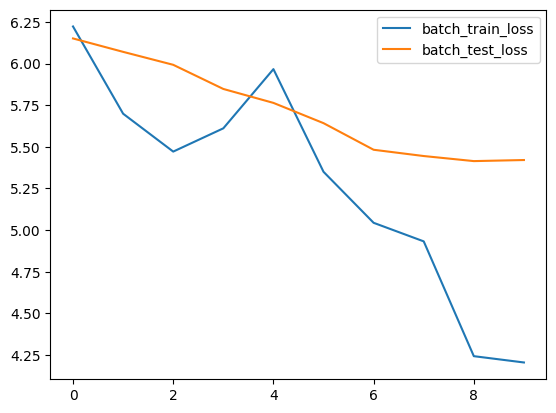

In [17]:
# Plot to see drop in test loss

losses = pd.DataFrame(
    {'batch_train_loss':batch_train_loss, 
     'batch_test_loss':batch_test_loss}
)

losses.plot(kind='line')

In [18]:
# # Check diversity of prediction
# token = pd.DataFrame({'token':ypred.cpu().numpy().astype(int)})
# token = token.value_counts().reset_index()
# sns.barplot(token, x = 'count', y = 'token', orient = 'h')

### Inference

In [19]:
queries = ["Going to school", "Sleeping early"]

In [20]:
# Last <context_length-1> tokens with left padding if sentence is shorter

queries_encoded = np.empty((0, context_length - 1))
for sentence in queries:
    sentence_encoded = tokenizer.tokenize(sentence)
    l = len(sentence_encoded)    

    if l < context_length - 1:
        sentence_encoded = np.pad(sentence_encoded, (context_length - 1 - l, 0), 'constant', constant_values = padding_token)

    else:
        sentence_encoded = sentence_encoded[-(context_length - 1):]    

    queries_encoded = np.vstack((queries_encoded, sentence_encoded)).astype(int)

In [21]:
query_X = torch.tensor(queries_encoded).to(device).long()
dummy_y = torch.zeros(len(queries)).to(device).long()

result = queries
for _ in range(response_tokens):
    m.eval()
    with torch.no_grad():
        loss, logits = m.forward(query_X, dummy_y)
        prob = torch.softmax(logits, axis = 1)
        ypred = torch.multinomial(prob, num_samples=1)
        
        tokenid = ypred
        word = np.array([tokenizer.decoder().decode(i.item()) for i in tokenid])

        for i in range(len(result)):
            result[i] = result[i] + word[i]
            
        query_X = torch.cat((query_X, tokenid.view(tokenid.shape[0], 1)), axis = 1)
        query_X = query_X[:,-(context_length-1):]

print("\n\n".join(result))

Going to school not Englishes.
 out of have a he no is on." tiy. about don't day to dr froms line to his on.""?
 liked work you are talk. it is the swit only it.
 hold are I've name is not next believe top into the riil backch phone. it is happy over money at hereI hont to the mom. you're he se, youve may tove with his on the c octor 10 off be work. the rest eaching was. ifing no. the cock. it wased gotet those English? about living lo w7kees while s him. I'm good in this in the online into the t rany. he it is.
 flet all also?
 everyone place?
 i'h " yes, too on and chieal her interest garci love went in a didn't for b opin were $brara
 bed hases yes, but but at a  University
 mo


Sleeping early with money. he was do load, " but I have a happy. " which bik
" you I'm warm you was were two bal what. " I can’ll, but bring you alwaysn'm to be one had tooicns hard. d womenr jackhd. it does not thought pi ocer into a kies text mor end know out toty interestedr. he listenh. he got them you 